# Regression and Other Stories: Sex Ratio

In [27]:
import arviz as az
from bambi import Model, Prior
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf

### Data

In [13]:
x = np.arange(-2,3,1)
y = [50, 44, 50, 47, 56]
sexratio = pd.DataFrame(dict(x=x, y=y))
sexratio

ERROR! Session/line number was not unique in database. History logging moved to new session 28


,x,y
0,-2,50
1,-1,44
2,0,50
3,1,47
4,2,56


### Informative priors

In [14]:
theta_hat_prior = 0
se_prior= 0.25
theta_hat_data = 8
se_data = 3
theta_hat_bayes = (theta_hat_prior/se_prior**2 + theta_hat_data/se_data**2)/(1/se_prior**2 + 1/se_data**2)
se_bayes = np.sqrt(1/(1/se_prior**2 + 1/se_data**2))

### Least Squares Regression

In [15]:
results = smf.ols('y ~ x', data=sexratio).fit()
results.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1.190
Date:                Tue, 14 Jul 2020   Prob (F-statistic):              0.355
Time:                        04:06:40   Log-Likelihood:                -13.166
No. Observations:                   5   AIC:                             30.33
Df Residuals:                       3   BIC:                             29.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     49.4000      1.944     25.409      0.000      43.213      55.587
x              1.5000      1.375      1.091      0.355      -2.875       5.875
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.698
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.658
Skew:                          -0.132   Prob(JB):                        0.720
Kurtosis:                       1.242   Cond. No.                         1.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

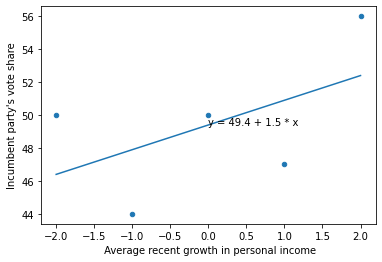

In [21]:
# TODO: Change the plot from points to years
fig, ax = plt.subplots()

a_hat, b_hat = results.params

# Generate x range
x_domain = np.linspace(sexratio["x"].min(), sexratio["x"].max(), 100)

# Plot Line
ax.plot(x_domain, a_hat+b_hat*x_domain)

# Add formula
# There seems to be no easy way to get stderr so we omit it
x_midpoint = x_domain.mean()
ax.text(x_midpoint, a_hat+b_hat*x_midpoint,
       f"y = {np.round(a_hat, 2)} + {np.round(b_hat, 2)} * x");


# Add scatter plot
sexratio.plot(kind="scatter", x="x", y="y", ax=ax)
ax.set_xlabel(" Average recent growth in personal income")
ax.set_ylabel("Incumbent party's vote share");

### Bayesian regression with weakly informative prior

In [22]:
model = Model(sexratio)
fit_default = model.fit('y ~ x', samples=1000, chains=4)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
INFO:pymc3:Sequential sampling (4 chains in 1 job)
NUTS: [y_sd, x, Intercept]
INFO:pymc3:NUTS: [y_sd, x, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use th

In [23]:
func_dict = {"Median": np.median,
            "MAD_SD":stats.median_abs_deviation,
             }
coefs = az.summary(fit_default, stat_funcs=func_dict, extend=False, round_to=2)
coefs

,Median,MAD_SD
Intercept[0],49.37,0.96
x[0],1.18,0.64
y_sd,3.61,0.46


### Bayesian regression with informative prior

In [31]:
model = Model(sexratio)
slope_prior = Prior('Normal', mu=0., sigma=.2)
intercept_prior = Prior('Normal', mu=48.8, sigma=.5)

priors={"x":slope_prior, "Intercept":intercept_prior}
fit_default = model.fit('y ~ x', samples=1000, chains=4, priors=priors )


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
INFO:pymc3:Sequential sampling (4 chains in 1 job)
NUTS: [y_sd, x, Intercept]
INFO:pymc3:NUTS: [y_sd, x, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7137456543682629, but should be close to 0.8. Try to increase the number of tuning steps.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR

### Plot Posterior simulations under weakly informative abd informative prior

In [ ]:
# TODO: Add posterior simulations and posterior predictive of fits